# Dependencies and notebook settings

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from tqdm import tqdm
from IPython.core.display import display, HTML
import ngboost
from sklearn.tree import DecisionTreeRegressor
from multiprocessing import Pool
from mp_cv import mp_cv, mp_cv_ET_hyp_tuning, mp_cv_ET_final_hyp_tuning
import os
from sklearn.model_selection import GridSearchCV

display(HTML("<style>.container { width:90% !important; }</style>"))
plt.style.use("ggplot")
mpl.rcParams["figure.dpi"] = 100
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# Data import 

In [2]:
df = pd.read_parquet("../dataset/spx_ngboost_final_dataset.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7652 entries, 1990-05-18 to 2020-09-30
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rr                  7652 non-null   float64
 1   Volume_L1           7652 non-null   float64
 2   OBV_L1              7652 non-null   float64
 3   Volume_L2           7652 non-null   float64
 4   EMA_W_L1            7652 non-null   float64
 5   Open_stationary_L3  7652 non-null   float64
 6   MA_L1               7652 non-null   float64
 7   EMA_L1              7652 non-null   float64
 8   MA_2_L3             7652 non-null   float64
 9   MA_W_L2             7652 non-null   float64
 10  MA_W_L3             7652 non-null   float64
 11  Volume_L3           7652 non-null   float64
 12  ATR_L2              7652 non-null   float64
 13  OBV_L3              7652 non-null   float64
 14  EMA_W_L3            7652 non-null   float64
 15  ADOSC_L3            7652 non-null   f

In [3]:
features = df.columns.tolist()
features.remove("rr")

# Choice of the functional form and the hyperparameters tuning 

List of the model hyperparameters:
1. The base learner (any Sci-kit Learn estimator, default: 3-depth Decision Tree) and it’s hyperparameters (I tried: Elastic Net, SVR, DT and RF, but due to computational complexity I have to choose only: Ridge, Decision Tree, Extra Decision Tree).
2. The output distribution (Normal, Laplace, T-student)
3. The number of boosting iterations (default: 500)
4. Learning rate (default: 0.01)

To increase speed of computations I will be using multiprocessing approach (for this purpose I prepared file/dependency mp_cv.py in the current directory) and additionally Google Colab and Kaggle Notebooks resources (so part of the outputs will be copy pasted from my Google Colab Notebooks and Kaggle Notebooks) but still I guarantee full reproducibility (on my local machine with following processor [link](https://ark.intel.com/content/www/us/en/ark/products/78934/intel-core-i7-4720hq-processor-6m-cache-up-to-3-60-ghz.html) computations took around 24 hours). 

In case of procedure: firstly I will look for the best base learner in the Walk Forward Cross-Validation per each training-validation period - I will receive 3 best learners (1 per each training-validation period). Then I will check performance of those best base learners on each training-validation period and choose the best one. I will start with model class choice: Ridge Regression, Extra Decision Tree, Decision Tree and then I will look for it's best hyperparameters. I choose number of VaR breaches and additionally financial provisions as scoring metrics!

Secondly I will look for the best hyperparameters from points 2,3 and 4 in the Walk Forward Cross-Validation grid search.

**The code isn't elegant in this chapter. There are a lot of repetitions here, which could be reduced to functions, while Jupyter Notebook / Lab has problems with Multiprocessing support, so correct code execution was more important than style/appearance.**

## The base learner choice

In [4]:
starts = ["2006-01-12", "2008-01-15", "2014-01-13"]

In [5]:
ridge_results = list()
ridge_results_ext = list()
extra_dt_results = list()
extra_dt_results_ext = list()
df_results = list()
df_results_ext = list()

### Period 1

In [6]:
df_tmp =  df.loc[starts[0]:].head(252 * 4).copy()
train_val = list()
base = "Ridge"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
ridge_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
ridge_results.append(output)
print(output)

[2.0, 4.0, 11377091.735246835, 8668995.835257072]


In [10]:
df_tmp =  df.loc[starts[0]:].head(252 * 4).copy()
train_val = list()
base = "ET"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
extra_dt_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
extra_dt_results.append(output)
print(output)

[2.0, 5.0, 10324293.367974924, 7911659.8899288]


In [11]:
df_tmp =  df.loc[starts[0]:].head(252 * 4).copy()
train_val = list()
base = "DT"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
df_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
df_results.append(output)
print(output)

[4.0, 11.0, 9482109.050627613, 7303451.770074699]


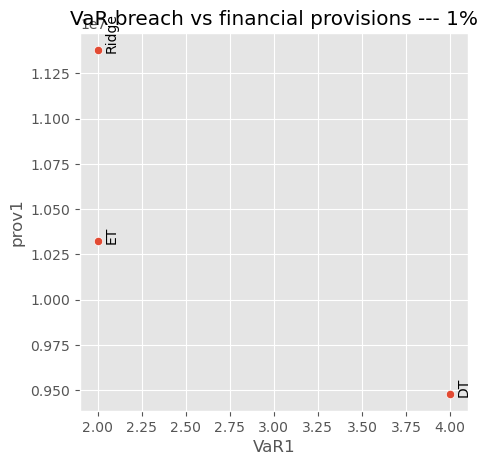

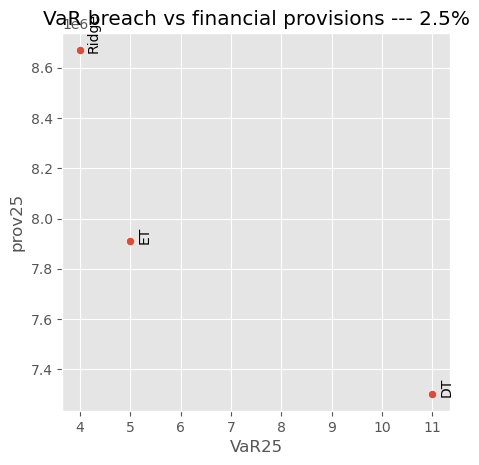

In [39]:
p1_output = pd.DataFrame([[2.0, 4.0, 11377091.735246835, 8668995.835257072],
 [2.0, 5.0, 10324293.367974924, 7911659.8899288],
[4.0, 11.0, 9482109.050627613, 7303451.770074699]], columns = ["VaR1", "VaR25","prov1","prov25"])
p1_output["model"] = ["Ridge","ET", "DT"]

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p1_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z in zip(p1_output.VaR1, p1_output.prov1, p1_output.model):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

sns.scatterplot(data=p1_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z in zip(p1_output.VaR25, p1_output.prov25, p1_output.model):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

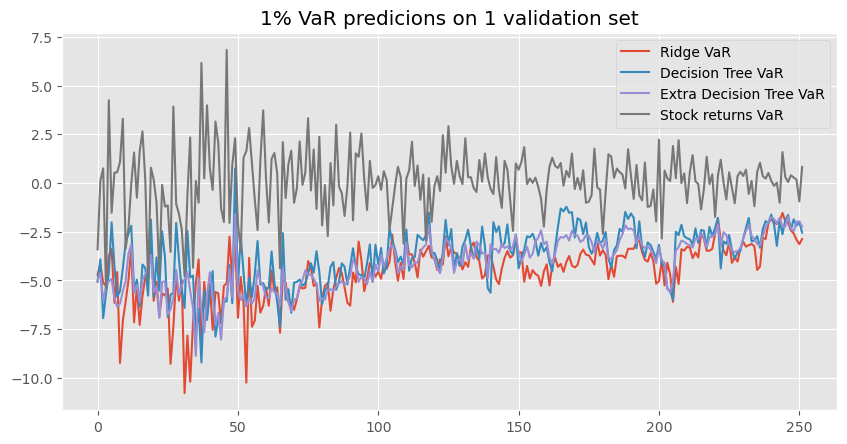

In [52]:
plt.rcParams["figure.figsize"] = (10, 5)
foo = pd.concat([ridge_results_ext[0].VaR1, df_results_ext[0].VaR1, extra_dt_results_ext[0].VaR1, extra_dt_results_ext[0].rr], axis=1)
foo.columns = ["Ridge VaR","Decision Tree VaR","Extra Decision Tree VaR","Stock returns VaR"]
foo.plot()
plt.title("1% VaR predicions on 1 validation set")
plt.show()

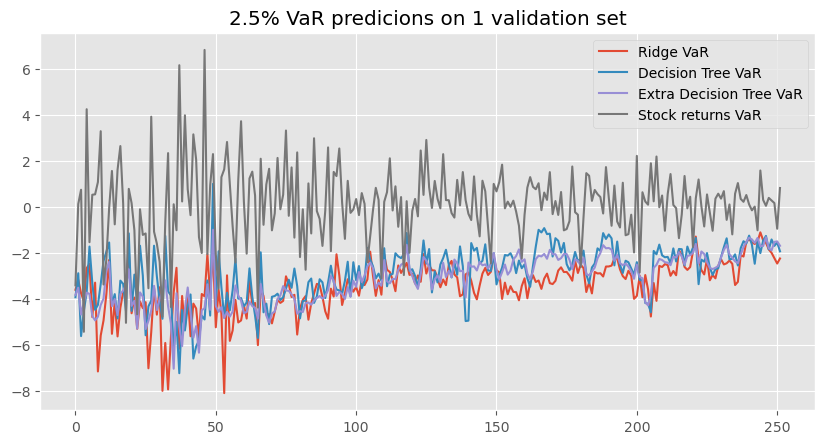

In [53]:
plt.rcParams["figure.figsize"] = (10, 5)
foo = pd.concat([ridge_results_ext[0].VaR25, df_results_ext[0].VaR25, extra_dt_results_ext[0].VaR25, extra_dt_results_ext[0].rr], axis=1)
foo.columns = ["Ridge VaR","Decision Tree VaR","Extra Decision Tree VaR","Stock returns VaR"]
foo.plot()
plt.title("2.5% VaR predicions on 1 validation set")
plt.show()

### Period 2

In [62]:
df_tmp =  df.loc[starts[1]:].head(252 * 4).copy()
train_val = list()
base = "Ridge"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
ridge_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
ridge_results.append(output)
print(output)

[5.0, 9.0, 8853691.283611866, 6796670.049190449]


In [63]:
df_tmp =  df.loc[starts[1]:].head(252 * 4).copy()
train_val = list()
base = "ET"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
extra_dt_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
extra_dt_results.append(output)
print(output)

[5.0, 12.0, 8560773.447158396, 6518683.494407859]


In [64]:
df_tmp =  df.loc[starts[1]:].head(252 * 4).copy()
train_val = list()
base = "DT"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
df_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
df_results.append(output)
print(output)

[6.0, 9.0, 8316053.924073018, 6338809.44453934]


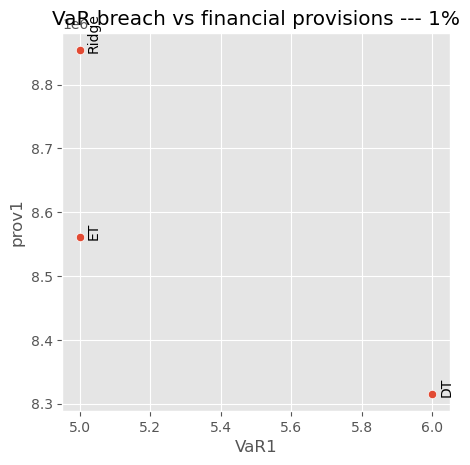

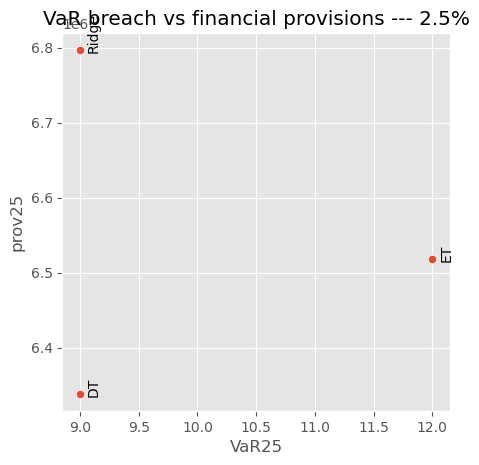

In [65]:
p2_output = pd.DataFrame([[5.0, 9.0, 8853691.283611866, 6796670.049190449],
                         [5.0, 12.0, 8560773.447158396, 6518683.494407859],
                          [6.0, 9.0, 8316053.924073018, 6338809.44453934]], columns = ["VaR1", "VaR25","prov1","prov25"])
p2_output["model"] = ["Ridge","ET", "DT"]

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p2_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z in zip(p2_output.VaR1, p2_output.prov1, p2_output.model):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

sns.scatterplot(data=p2_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z in zip(p2_output.VaR25, p2_output.prov25, p2_output.model):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

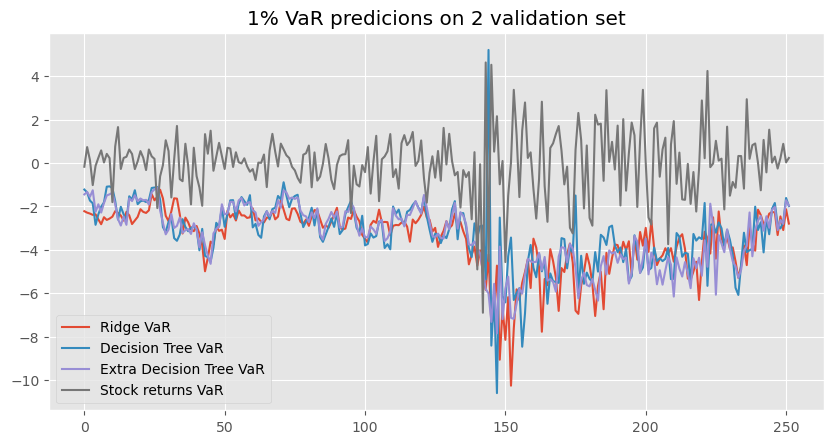

In [66]:
plt.rcParams["figure.figsize"] = (10, 5)
foo = pd.concat([ridge_results_ext[2].VaR1, df_results_ext[2].VaR1, extra_dt_results_ext[2].VaR1, extra_dt_results_ext[2].rr], axis=1)
foo.columns = ["Ridge VaR","Decision Tree VaR","Extra Decision Tree VaR","Stock returns VaR"]
foo.plot()
plt.title("1% VaR predicions on 2 validation set")
plt.show()

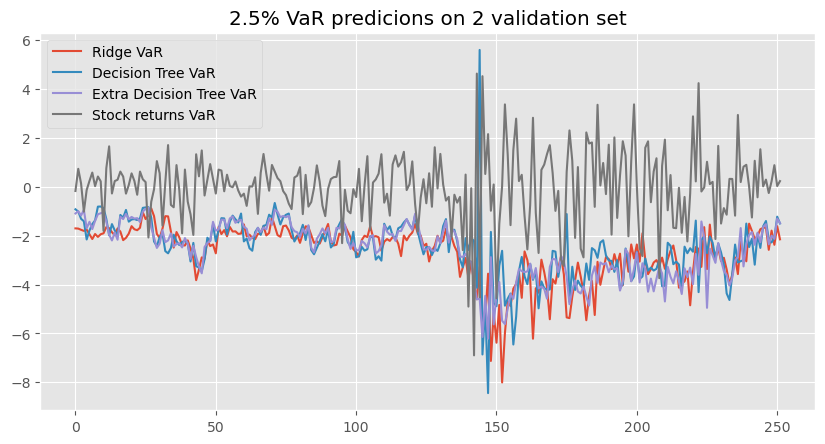

In [67]:
plt.rcParams["figure.figsize"] = (10, 5)
foo = pd.concat([ridge_results_ext[2].VaR25, df_results_ext[2].VaR25, extra_dt_results_ext[2].VaR25, extra_dt_results_ext[2].rr], axis=1)
foo.columns = ["Ridge VaR","Decision Tree VaR","Extra Decision Tree VaR","Stock returns VaR"]
foo.plot()
plt.title("2.5% VaR predicions on 2 validation set")
plt.show()

### Period 3

In [54]:
df_tmp =  df.loc[starts[2]:].head(252 * 4).copy()
train_val = list()
base = "Ridge"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
ridge_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
ridge_results.append(output)
print(output)

[3.0, 3.0, 3501832.52379613, 2673166.8351452476]


In [55]:
df_tmp =  df.loc[starts[2]:].head(252 * 4).copy()
train_val = list()
base = "ET"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
extra_dt_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
extra_dt_results.append(output)
print(output)

[3.0, 4.0, 3140311.5685326993, 2405485.2311148457]


In [56]:
df_tmp =  df.loc[starts[2]:].head(252 * 4).copy()
train_val = list()
base = "DT"
for i in range(0,252):
    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], base])

if __name__ ==  '__main__': 
    num_proces = os.cpu_count()
    p = Pool(processes = num_proces)
    output = p.map(mp_cv, train_val)
    p.close()
    p.join()

output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
output["rr"] = df_tmp.tail(252)["rr"].tolist()
output["exceed1"] = output["rr"] < output.VaR1
output["exceed25"] = output["rr"] < output.VaR25
output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
df_results_ext.append(output)
output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
df_results.append(output)
print(output)

[3.0, 6.0, 3054496.68868982, 2339291.1923271134]


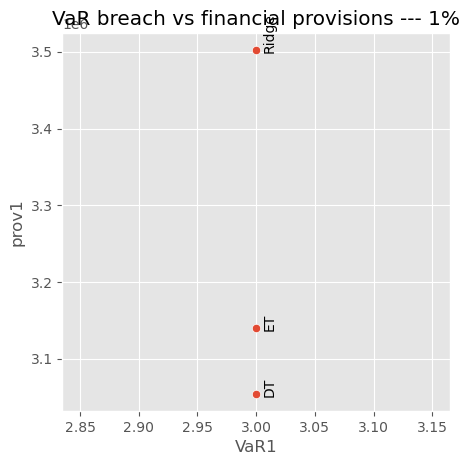

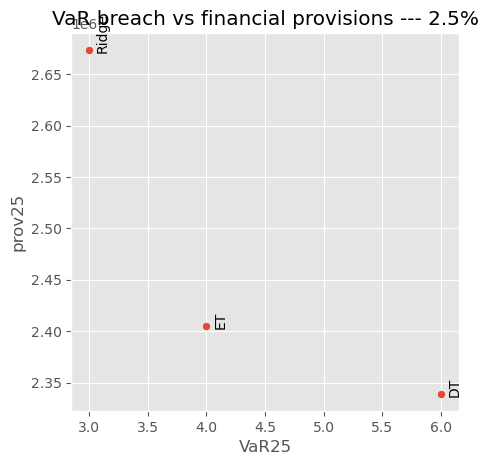

In [57]:
p3_output = pd.DataFrame([[3.0, 3.0, 3501832.52379613, 2673166.8351452476],
 [3.0, 4.0, 3140311.5685326993, 2405485.2311148457],
[3.0, 6.0, 3054496.68868982, 2339291.1923271134]], columns = ["VaR1", "VaR25","prov1","prov25"])
p3_output["model"] = ["Ridge","ET", "DT"]

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p3_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z in zip(p3_output.VaR1, p3_output.prov1, p3_output.model):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

sns.scatterplot(data=p3_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z in zip(p3_output.VaR25, p3_output.prov25, p3_output.model):
    label = z
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=90)

plt.show()

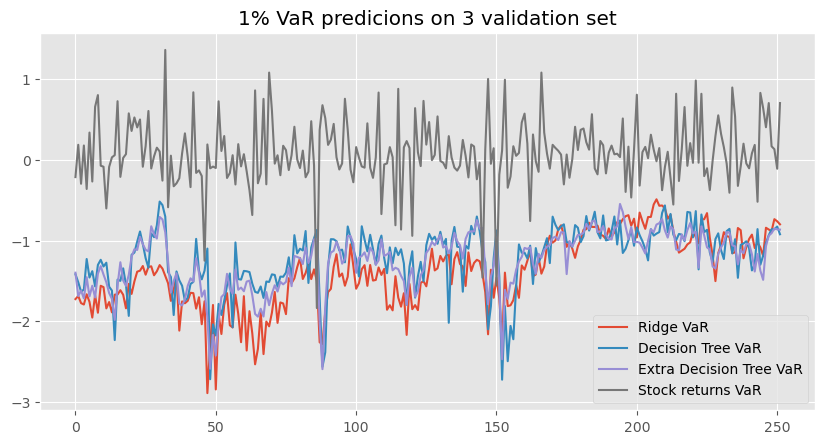

In [60]:
plt.rcParams["figure.figsize"] = (10, 5)
foo = pd.concat([ridge_results_ext[1].VaR1, df_results_ext[1].VaR1, extra_dt_results_ext[1].VaR1, extra_dt_results_ext[1].rr], axis=1)
foo.columns = ["Ridge VaR","Decision Tree VaR","Extra Decision Tree VaR","Stock returns VaR"]
foo.plot()
plt.title("1% VaR predicions on 3 validation set")
plt.show()

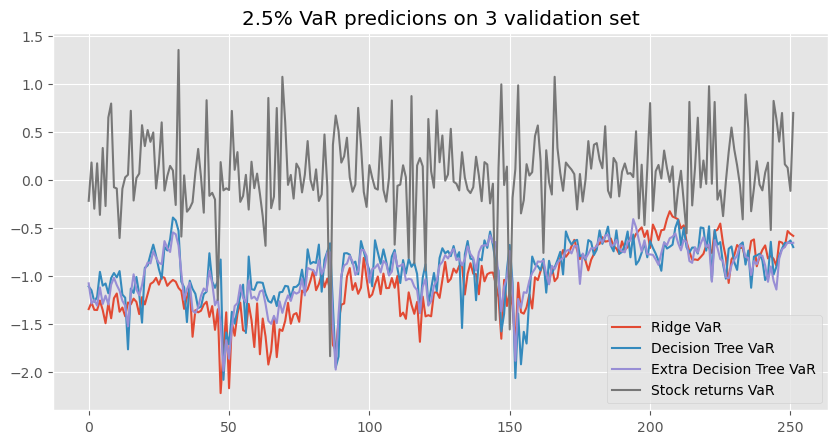

In [61]:
plt.rcParams["figure.figsize"] = (10, 5)
foo = pd.concat([ridge_results_ext[1].VaR25, df_results_ext[1].VaR25, extra_dt_results_ext[1].VaR25, extra_dt_results_ext[1].rr], axis=1)
foo.columns = ["Ridge VaR","Decision Tree VaR","Extra Decision Tree VaR","Stock returns VaR"]
foo.plot()
plt.title("2.5% VaR predicions on 3 validation set")
plt.show()

Generally we can see that Extra Decision Tree works the best - it deals really well with the trade-off between financial provisions and number of breaches in every training-validation period! 

### Hyperparameters tunning for the base learner of my choice - extremely randomized tree regressor

In [26]:
params = {"max_depth":[2,3,4], "min_samples_split":[2,3]}
outputs1 = list()
outputs2 = list()
outputs3 = list()

#### Period 1 

In [27]:
df_tmp = df.loc[starts[0]:].head(252 * 4).copy()

if __name__ ==  '__main__': 
    for ii in params["max_depth"]:
        for jj in params["min_samples_split"]:
            train_val = list()
            for i in range(0,252):
                train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], ii, jj])
            num_proces = os.cpu_count()
            p = Pool(processes = num_proces)
            output = p.map(mp_cv_ET_hyp_tuning, train_val)
            output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
            output["rr"] = df_tmp.tail(252)["rr"].tolist()
            output["exceed1"] = output["rr"] < output.VaR1
            output["exceed25"] = output["rr"] < output.VaR25
            output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
            output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
            output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
            output.extend([ii,jj])
            outputs1.append(output)
            p.close()
            p.join()

,VaR1,VaR25,prov1,prov25,max_depth,min_samples_split
0,1.0,6.0,1.093924e+07,8.374698e+06,2,2
1,1.0,6.0,1.092859e+07,8.365795e+06,2,3
2,2.0,4.0,1.033512e+07,7.921610e+06,3,2
3,2.0,4.0,1.043215e+07,7.996742e+06,3,3
4,3.0,7.0,9.731496e+06,7.477415e+06,4,2
5,2.0,7.0,9.782912e+06,7.513334e+06,4,3


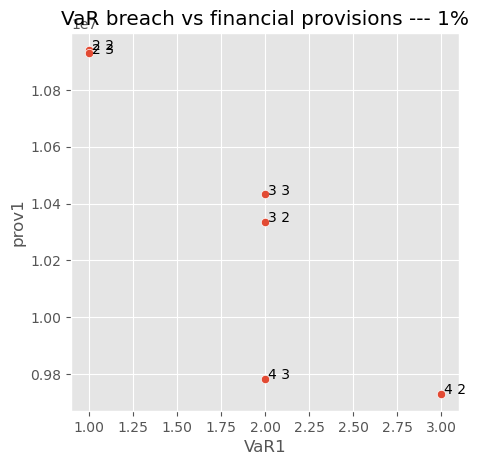

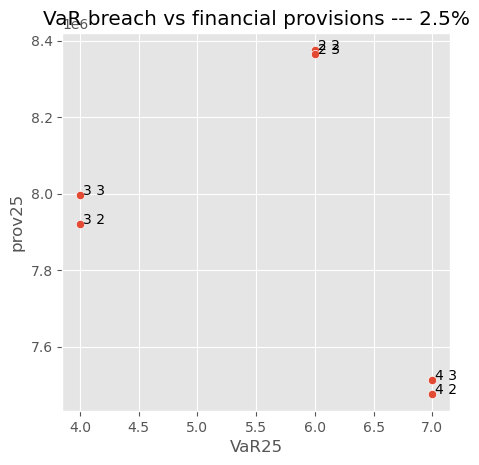

In [49]:
p1_output = pd.DataFrame(outputs1, columns = ["VaR1", "VaR25","prov1","prov25", "max_depth", "min_samples_split"])
display(p1_output)

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p1_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za in zip(p1_output.VaR1, p1_output.prov1, p1_output.max_depth, p1_output.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=p1_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za in zip(p1_output.VaR25, p1_output.prov25, p1_output.max_depth, p1_output.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

#### Period 2

In [28]:
df_tmp =  df.loc[starts[1]:].head(252 * 4).copy()

if __name__ ==  '__main__': 
    for ii in params["max_depth"]:
        for jj in params["min_samples_split"]:
            train_val = list()
            for i in range(0,252):
                train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], ii, jj])
            num_proces = os.cpu_count()
            p = Pool(processes = num_proces)
            output = p.map(mp_cv_ET_hyp_tuning, train_val)
            output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
            output["rr"] = df_tmp.tail(252)["rr"].tolist()
            output["exceed1"] = output["rr"] < output.VaR1
            output["exceed25"] = output["rr"] < output.VaR25
            output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
            output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
            output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
            output.extend([ii,jj])
            outputs2.append(output)
            p.close()
            p.join()

,VaR1,VaR25,prov1,prov25,max_depth,min_samples_split
0,5.0,10.0,9.000423e+06,6.852385e+06,2,2
1,5.0,11.0,8.922689e+06,6.790549e+06,2,3
2,5.0,12.0,8.604692e+06,6.552808e+06,3,2
3,5.0,13.0,8.590289e+06,6.535753e+06,3,3
4,6.0,14.0,8.112163e+06,6.177482e+06,4,2
5,6.0,13.0,8.166653e+06,6.217287e+06,4,3


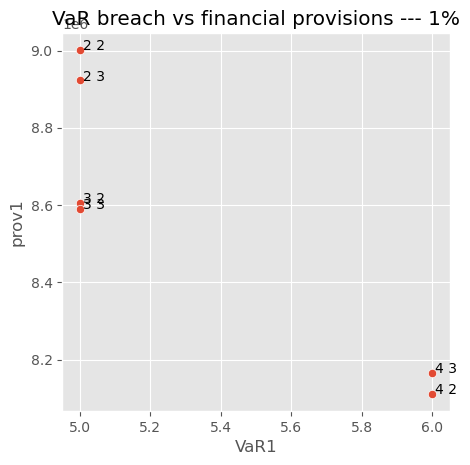

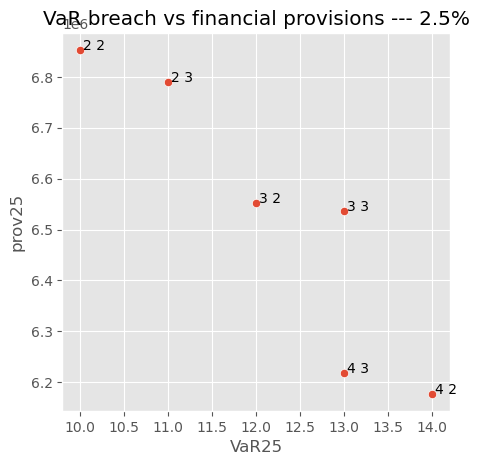

In [50]:
p2_output = pd.DataFrame(outputs2, columns = ["VaR1", "VaR25","prov1","prov25", "max_depth", "min_samples_split"])
display(p2_output)

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p2_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za in zip(p2_output.VaR1, p2_output.prov1, p2_output.max_depth, p2_output.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=p2_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za in zip(p2_output.VaR25, p2_output.prov25, p2_output.max_depth, p2_output.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

#### Period 3

In [29]:
df_tmp =  df.loc[starts[2]:].head(252 * 4).copy()

if __name__ ==  '__main__': 
    for ii in params["max_depth"]:
        for jj in params["min_samples_split"]:
            train_val = list()
            for i in range(0,252):
                train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], ii, jj])
            num_proces = os.cpu_count()
            p = Pool(processes = num_proces)
            output = p.map(mp_cv_ET_hyp_tuning, train_val)
            output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
            output["rr"] = df_tmp.tail(252)["rr"].tolist()
            output["exceed1"] = output["rr"] < output.VaR1
            output["exceed25"] = output["rr"] < output.VaR25
            output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
            output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
            output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
            output.extend([ii,jj])
            outputs3.append(output)
            p.close()
            p.join()

,VaR1,VaR25,prov1,prov25,max_depth,min_samples_split
0,3.0,4.0,3.279441e+06,2.508825e+06,2,2
1,3.0,3.0,3.276031e+06,2.506029e+06,2,3
2,3.0,3.0,3.123665e+06,2.392804e+06,3,2
3,3.0,3.0,3.142528e+06,2.407283e+06,3,3
4,3.0,4.0,2.980463e+06,2.284816e+06,4,2
5,3.0,5.0,2.981488e+06,2.285510e+06,4,3


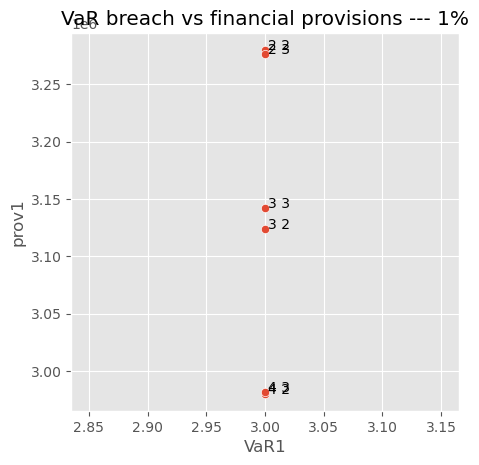

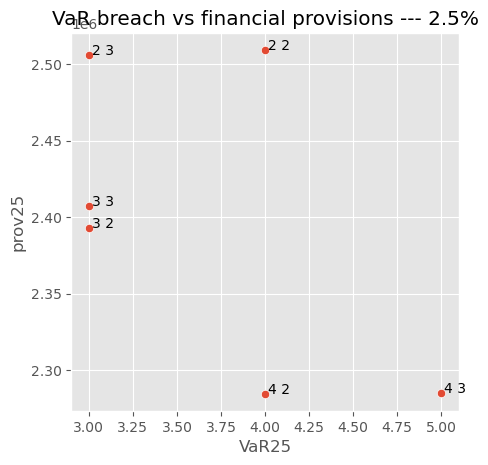

In [51]:
p3_output = pd.DataFrame(outputs3, columns = ["VaR1", "VaR25","prov1","prov25", "max_depth", "min_samples_split"])
display(p3_output)

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p3_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za in zip(p3_output.VaR1, p3_output.prov1, p3_output.max_depth, p3_output.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=p3_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za in zip(p3_output.VaR25, p3_output.prov25, p3_output.max_depth, p3_output.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

#### Average over periods

In [61]:
paverage = pd.concat([p1_output, p2_output, p3_output])
paverage = paverage.groupby(["max_depth","min_samples_split"], as_index=False).mean()

In [62]:
display(paverage)

,max_depth,min_samples_split,VaR1,VaR25,prov1,prov25
0,2,2,3.000000,6.666667,7.739701e+06,5.911969e+06
1,2,3,3.000000,6.666667,7.709102e+06,5.887458e+06
2,3,2,3.333333,6.333333,7.354491e+06,5.622407e+06
3,3,3,3.333333,6.666667,7.388324e+06,5.646593e+06
4,4,2,4.000000,8.333333,6.941374e+06,5.313238e+06
5,4,3,3.666667,8.333333,6.977018e+06,5.338710e+06


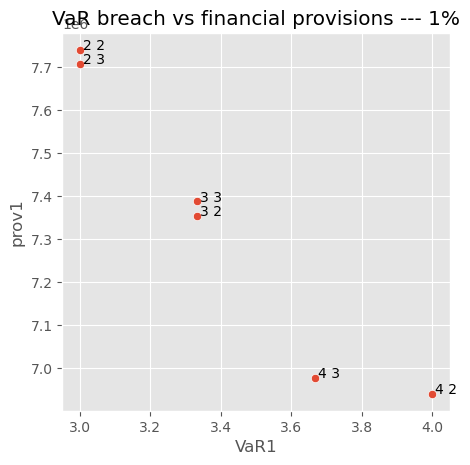

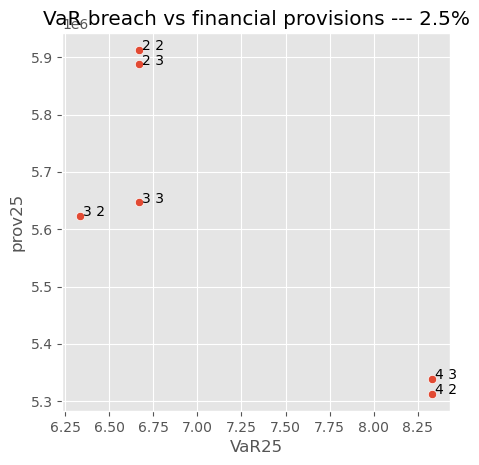

In [64]:
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=paverage, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za in zip(paverage.VaR1, paverage.prov1, paverage.max_depth, paverage.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=paverage, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za in zip(paverage.VaR25, paverage.prov25, paverage.max_depth, paverage.min_samples_split):
    label = str(z) + " " + str(za)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

Based on above analysis I claim that quasi optimal max_depth is equal to 3 and min_samples_split is 2. 

## Hyperparameters tuning: distribution, boosting iterations, ETA  

In [19]:
params = {"dist":["Laplace", "Normal", "T"], "eta":[0.01, 0.1, 0.25], "it": [100, 250, 500]}
outputs1 = list()
outputs2 = list()
outputs3 = list()

#### Period 1 

In [8]:
df_tmp = df.loc[starts[0]:].head(252 * 4).copy()

if __name__ ==  '__main__': 
    for ii in tqdm(params["dist"]):
        for jj in params["eta"]:
            for kk in params["it"]:
                train_val = list()
                for i in range(0,252):
                    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], ii, jj, kk])
                num_proces = os.cpu_count()
                p = Pool(processes = num_proces)
                output = p.map(mp_cv_ET_final_hyp_tuning, train_val)
                output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
                output["rr"] = df_tmp.tail(252)["rr"].tolist()
                output["exceed1"] = output["rr"] < output.VaR1
                output["exceed25"] = output["rr"] < output.VaR25
                output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
                output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
                output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
                output.extend([ii,jj, kk])
                outputs1.append(output)
                p.close()
                p.join()

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:29:42<00:00, 1794.25s/it]


,VaR1,VaR25,prov1,prov25,dist,eta,it
0,1.0,4.0,1.158696e+07,8.848929e+06,Laplace,0.01,100
1,1.0,5.0,1.091662e+07,8.346723e+06,Laplace,0.01,250
2,2.0,5.0,1.041583e+07,7.984297e+06,Laplace,0.01,500
3,2.0,14.0,9.925981e+06,7.630077e+06,Laplace,0.10,100
4,7.0,14.0,8.789874e+06,6.799474e+06,Laplace,0.10,250
5,9.0,17.0,8.326876e+06,6.463731e+06,Laplace,0.10,500
6,9.0,18.0,9.470193e+06,7.442827e+06,Laplace,0.25,100
7,18.0,24.0,7.379697e+06,5.821236e+06,Laplace,0.25,250
8,23.0,39.0,6.672098e+06,5.318102e+06,Laplace,0.25,500
9,3.0,7.0,9.547040e+06,8.080204e+06,Normal,0.01,100


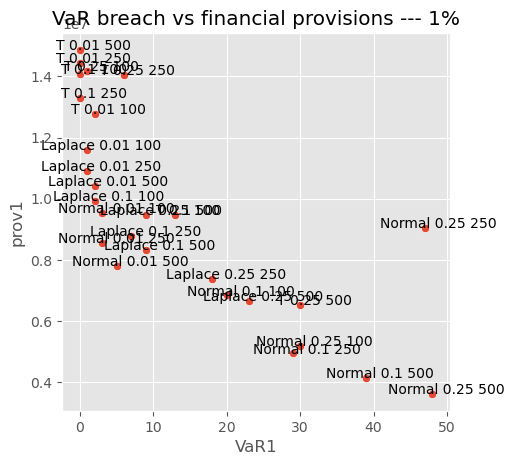

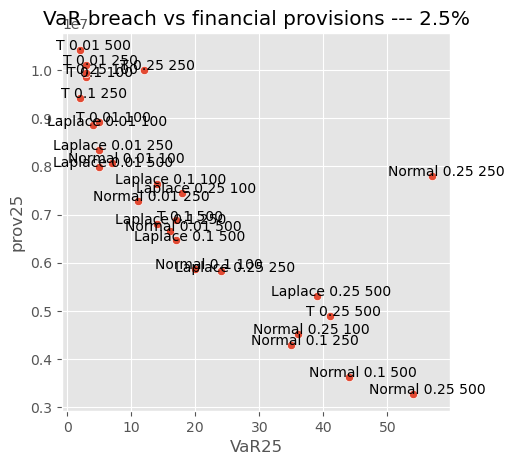

In [11]:
p1_output = pd.DataFrame(outputs1, columns = ["VaR1", "VaR25","prov1","prov25", "dist", "eta", "it"])
display(p1_output)

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p1_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za, zb in zip(p1_output.VaR1, p1_output.prov1, p1_output.dist, p1_output.eta, p1_output.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=p1_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za, zb in zip(p1_output.VaR25, p1_output.prov25, p1_output.dist, p1_output.eta, p1_output.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

#### Period 2

In [23]:
df_tmp = df.loc[starts[1]:].head(252 * 4).copy()

if __name__ ==  '__main__': 
    for ii in tqdm(params["dist"]):
        for jj in params["eta"]:
            for kk in params["it"]:
                train_val = list()
                for i in range(0,252):
                    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], ii, jj, kk])
                num_proces = os.cpu_count()
                p = Pool(processes = num_proces)
                output = p.map(mp_cv_ET_final_hyp_tuning, train_val)
                output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
                output["rr"] = df_tmp.tail(252)["rr"].tolist()
                output["exceed1"] = output["rr"] < output.VaR1
                output["exceed25"] = output["rr"] < output.VaR25
                output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
                output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
                output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
                output.extend([ii,jj, kk])
                outputs2.append(output)
                p.close()
                p.join()

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:29:17<00:00, 1785.82s/it]


,VaR1,VaR25,prov1,prov25,dist,eta,it
0,2.0,5.0,9.933296e+06,7.553511e+06,Laplace,0.01,100
1,5.0,10.0,9.142119e+06,6.954534e+06,Laplace,0.01,250
2,5.0,12.0,8.570907e+06,6.523645e+06,Laplace,0.01,500
3,8.0,12.0,8.189343e+06,6.247573e+06,Laplace,0.10,100
4,10.0,13.0,7.569988e+06,5.774179e+06,Laplace,0.10,250
5,9.0,19.0,7.180699e+06,5.488285e+06,Laplace,0.10,500
6,11.0,19.0,8.317464e+06,6.384132e+06,Laplace,0.25,100
7,17.0,25.0,6.772332e+06,5.226537e+06,Laplace,0.25,250
8,18.0,27.0,6.176257e+06,4.791540e+06,Laplace,0.25,500
9,3.0,9.0,8.183348e+06,6.897561e+06,Normal,0.01,100


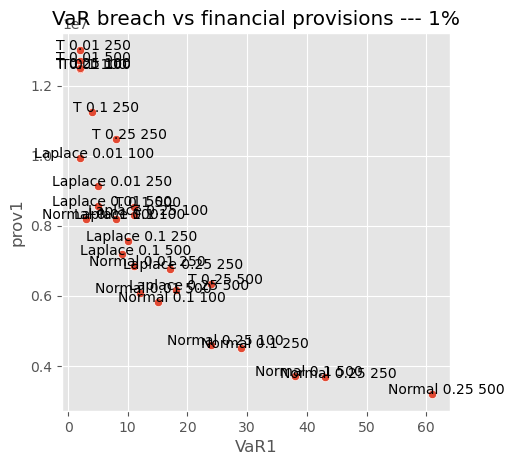

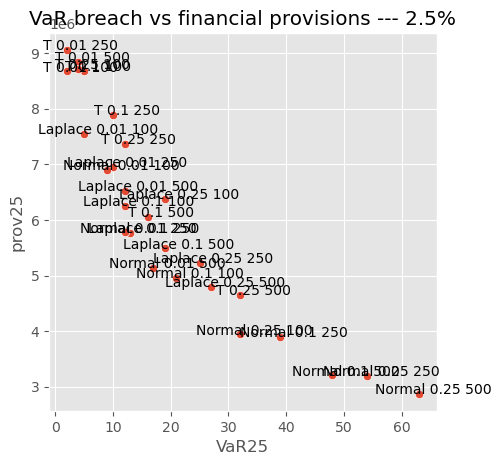

In [24]:
p2_output = pd.DataFrame(outputs2, columns = ["VaR1", "VaR25","prov1","prov25", "dist", "eta", "it"])
display(p2_output)

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p2_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za, zb in zip(p2_output.VaR1, p2_output.prov1, p2_output.dist, p2_output.eta, p2_output.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=p2_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za, zb in zip(p2_output.VaR25, p2_output.prov25, p2_output.dist, p2_output.eta, p2_output.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

#### Period 3

In [25]:
df_tmp = df.loc[starts[2]:].head(252 * 4).copy()

if __name__ ==  '__main__': 
    for ii in tqdm(params["dist"]):
        for jj in params["eta"]:
            for kk in params["it"]:
                train_val = list()
                for i in range(0,252):
                    train_val.append([df_tmp.iloc[i : i + 252 * 3], df_tmp.iloc[i + 252 * 3 : i + 252 * 3 +1], ii, jj, kk])
                num_proces = os.cpu_count()
                p = Pool(processes = num_proces)
                output = p.map(mp_cv_ET_final_hyp_tuning, train_val)
                output = pd.DataFrame(output, columns = ["VaR1", "VaR25"])
                output["rr"] = df_tmp.tail(252)["rr"].tolist()
                output["exceed1"] = output["rr"] < output.VaR1
                output["exceed25"] = output["rr"] < output.VaR25
                output["provisions_VaR1"] = 1e4 * abs(output.VaR1)
                output["provisions_VaR25"] = 1e4 * abs(output.VaR25)
                output = output[['exceed1', 'exceed25', 'provisions_VaR1','provisions_VaR25']].sum().tolist()
                output.extend([ii,jj, kk])
                outputs3.append(output)
                p.close()
                p.join()

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:22:48<00:00, 1656.29s/it]


,VaR1,VaR25,prov1,prov25,dist,eta,it
0,2.0,3.0,4.015771e+06,3.067554e+06,Laplace,0.01,100
1,3.0,3.0,3.316304e+06,2.534284e+06,Laplace,0.01,250
2,3.0,3.0,3.135019e+06,2.402240e+06,Laplace,0.01,500
3,3.0,5.0,3.049536e+06,2.343025e+06,Laplace,0.10,100
4,3.0,7.0,2.801100e+06,2.152413e+06,Laplace,0.10,250
5,4.0,8.0,2.635747e+06,2.020587e+06,Laplace,0.10,500
6,3.0,6.0,2.721895e+06,2.095168e+06,Laplace,0.25,100
7,5.0,14.0,2.487792e+06,1.905823e+06,Laplace,0.25,250
8,12.0,17.0,2.222840e+06,1.705415e+06,Laplace,0.25,500
9,3.0,3.0,3.388900e+06,2.852040e+06,Normal,0.01,100


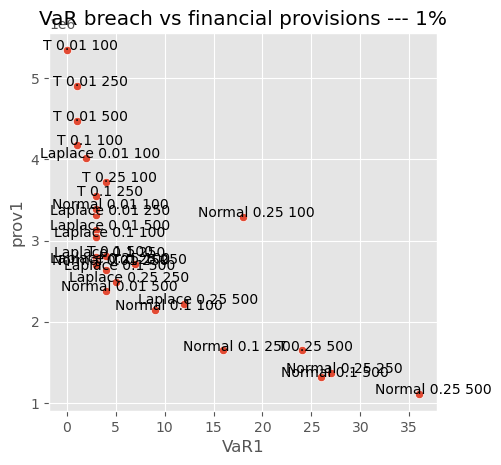

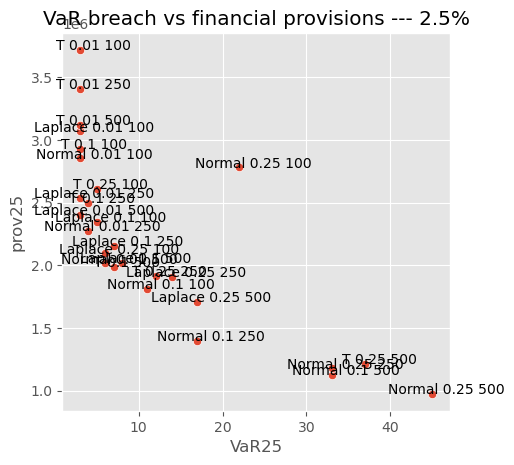

In [26]:
p3_output = pd.DataFrame(outputs3, columns = ["VaR1", "VaR25","prov1","prov25", "dist", "eta", "it"])
display(p3_output)

mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=p3_output, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za, zb in zip(p3_output.VaR1, p3_output.prov1, p3_output.dist, p3_output.eta, p3_output.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=p3_output, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za, zb in zip(p3_output.VaR25, p3_output.prov25, p3_output.dist, p3_output.eta, p3_output.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

#### Average over periods

In [27]:
paverage = pd.concat([p1_output, p2_output, p3_output])
paverage = paverage.groupby(["dist", "eta", "it"], as_index=False).mean()

In [28]:
display(paverage)

,dist,eta,it,VaR1,VaR25,prov1,prov25
0,Laplace,0.01,100,1.666667,4.000000,8.512010e+06,6.489998e+06
1,Laplace,0.01,250,3.000000,6.000000,7.791681e+06,5.945180e+06
2,Laplace,0.01,500,3.333333,6.666667,7.373920e+06,5.636727e+06
3,Laplace,0.10,100,4.333333,10.333333,7.054953e+06,5.406892e+06
4,Laplace,0.10,250,6.666667,11.333333,6.386987e+06,4.908688e+06
5,Laplace,0.10,500,7.333333,14.666667,6.047774e+06,4.657534e+06
6,Laplace,0.25,100,7.666667,14.333333,6.836517e+06,5.307376e+06
7,Laplace,0.25,250,13.333333,21.000000,5.546607e+06,4.317865e+06
8,Laplace,0.25,500,17.666667,27.666667,5.023732e+06,3.938352e+06
9,Normal,0.01,100,3.000000,6.333333,7.039763e+06,5.943269e+06


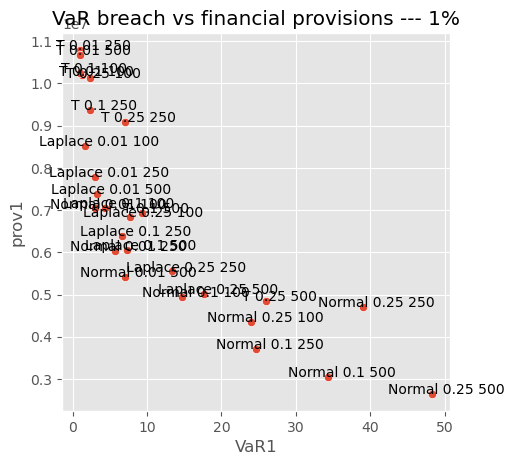

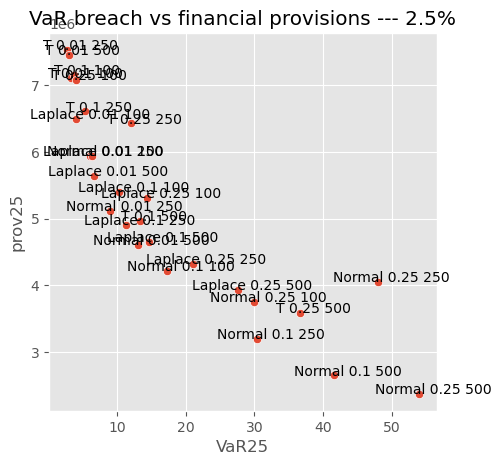

In [30]:
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (5, 5)
sns.scatterplot(data=paverage, x="VaR1", y="prov1")
plt.title("VaR breach vs financial provisions --- 1%")

for x, y, z, za, zb in zip(paverage.VaR1, paverage.prov1, paverage.dist, paverage.eta, paverage.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()

sns.scatterplot(data=paverage, x="VaR25", y="prov25")
plt.title("VaR breach vs financial provisions --- 2.5%")

for x, y, z, za, zb in zip(paverage.VaR25, paverage.prov25, paverage.dist, paverage.eta, paverage.it):
    label = str(z) + " " + str(za) + " " + str(zb)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(10, 0), ha="center", rotation=0)

plt.show()